In [1]:
using Pkg
Pkg.activate("BosonStars")
using Revise
using Skylight
using StatsBase
using CairoMakie
using LinearAlgebra
using Printf
using Colors
using DataFrames
using GLM
using DelimitedFiles
includet("corona.jl")
includet("ranges.jl")
includet("juliacolors.jl")

  Activating project at `~/BosonStars/BosonStars`


In [14]:
function calculate_profile(modelname, modelid; height, npp, nbins, save=true, plot=false)

    filenames = get_filenames(modelname)
    obs_configurations = load_configurations_from_hdf5("io/$(filenames[modelid,1]).h5")
    spacetime = obs_configurations.spacetime
    disk = obs_configurations.radiative_model
    corona = LamppostCorona(height=height, theta_offset=1e-5, spectral_index = 2.0)
    configurations = VacuumETOConfigurations(spacetime=spacetime,
                                    radiative_model = corona,
                                    number_of_points=1,
                                    number_of_packets_per_point = npp, 
                                    max_radius = 110.0,
                                    unit_mass_in_solar_masses=1.0)
    initial_data = initialize(configurations)
    cbp = callback_parameters(spacetime, disk, configurations)
    cb = callback(spacetime, disk)
    sim = integrate(initial_data, configurations, cb, cbp; method=VCABM(), reltol=1e-5, abstol=1e-5)
    output_data = sim.output_data
    at_source = map(position -> is_final_position_at_source(position, spacetime, disk) && position[3] ≈ π/2, eachcol(output_data))
    radii = output_data[2,at_source]
    q = energies_quotients(output_data[:,at_source], spacetime, disk)
    # bins = radial_bins(disk, nbins=100)
    bins = range(cbrt(disk.inner_radius), stop=cbrt(disk.outer_radius), length=nbins).^3
    A = ring_areas(bins, spacetime)
    γ = lorentz_factors(bins, spacetime, disk)
    h = fit(Histogram, radii, bins)
    h = normalize(h, mode=:probability)
    𝓝 = h.weights

    qavg = average_inside_radial_bins(q, radii, bins)

    Γ = corona.spectral_index
    n = 𝓝./(A.*γ)
    I = qavg.^Γ.*n

    bins_midpoints = 0.5*(bins[1:end-1] + bins[2:end])
    hstr = string(@sprintf("%02d", corona.height))
    istr = string(@sprintf("%02d", corona.spectral_index))
    filename = "$(modelname)$(modelid)_h$(hstr)_idx$(istr)"
    savename = "io/corona/bosonstar/$(filename).txt"
    figname = "plots/profiles/$(filename).png"

    if save
        open(savename, "w") do io
            writedlm(io, [bins_midpoints I])
        end
    end

    if plot
        fig = Figure(resolution=(400,400))
        ax = Axis(fig[1,1])
        lines!(ax, bins_midpoints, I)
        ax.xscale = log10
        ax.yscale = log10
        # xlims!(1.0,200)
        # ylims!(1e-6, 1e0)
        ax.xtickformat = "{:.1f}"
        display(fig)
        CairoMakie.save(figname, fig)
    end
    return nothing 
end

calculate_profile (generic function with 1 method)

In [182]:
modelname = "SBS"
modelid = 2
h = 5.0
npp = 5000000
filenames = get_filenames(modelname)
obs_configurations = load_configurations_from_hdf5("io/$(filenames[modelid,1]).h5")
spacetime = obs_configurations.spacetime
corona = LamppostCorona(height=h, theta_offset=1e-5, spectral_index = 2.0)
configurations = VacuumETOConfigurations(spacetime=spacetime,
        radiative_model = corona,
        number_of_points=1,
        number_of_packets_per_point = npp, 
        max_radius = 110.0,
        unit_mass_in_solar_masses=1.0)
initial_data = initialize(configurations)
disk = obs_configurations.radiative_model
plane = NovikovThorneDisk(inner_radius = 0.0, outer_radius = disk.outer_radius)
cbp = callback_parameters(spacetime, plane, configurations)
cb = callback(spacetime, plane)
sim = integrate(initial_data, configurations, cb, cbp; method=VCABM(), reltol=1e-5, abstol=1e-5)
output_data = sim.output_data


┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=5.123267356698382e-5, and step error estimate = 0.9659391116782853. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=5.5270475817558576e-5, and step error estimate = 7.638513341170441. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=5.7218105454803615e-5, and step error estimate = 0.7951500328611433. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ W

┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=5.000514808028349e-5, and step error estimate = 0.886990530545568. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=6.809808146913687e-5, and step error estimate = 1.7745138318435016. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=5.411928343010805e-5, and step error estimate = 2.9909132982883384. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ War

┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=6.20868063992428e-5, and step error estimate = 2.436740433042859. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599


Equations integration stats:
Wall clock time: 150.911873389 seconds
Memory allocated: 544.505 GiB


8×5000000 Matrix{Float64}:
 17.924       115.503        115.403        …  117.573        117.554
 13.4154      110.0          110.0             110.0          110.0
  1.5708        1.1802         1.15989           1.54891        1.54619
  1.31829       2.99501        0.670955         -0.725035      -1.74608
  0.91027       0.788924       0.788937          0.788923       0.788922
  0.694995      0.77369        0.773697     …    0.773372       0.773396
  0.0276364     0.000330756    0.000326454       0.000382946    0.000382692
  2.78963e-7    2.97043e-10    1.88708e-9       -2.15229e-9    -3.29897e-9

In [183]:
at_source = map(ray -> is_final_position_at_source(ray[1:4], spacetime, disk) && ray[3] ≈ π/2 && abs(Skylight.norm_squared(ray[5:8], metric(ray[1:4], spacetime))) < 1e-2, eachcol(output_data))
radii = output_data[2,at_source]
q = energies_quotients(output_data[:,at_source], spacetime, disk)

1466154-element Vector{Float64}:
 0.8791153161723221
 0.898649413982072
 0.920638740987576
 0.8368475669794718
 0.790912143029144
 0.9359825297752112
 0.8305123656227772
 1.0683489637808714
 0.9509603996961217
 0.9589912196135497
 ⋮
 0.9930767419888642
 0.9319432894284095
 1.05686942406963
 0.8537331356139339
 0.8241884326777821
 0.8552266697627112
 0.9386681593253078
 0.8206108634669877
 0.8101396095685997

In [184]:
# bins = radial_bins(disk, nbins=100)
nbins = 50
bins = range(cbrt(disk.inner_radius), stop=cbrt(disk.outer_radius), length=nbins).^3
A = ring_areas(bins, spacetime)
γ = lorentz_factors(bins, spacetime, disk)
h = fit(Histogram, radii, bins)
h = normalize(h, mode=:probability)
𝓝 = h.weights


49-element Vector{Float64}:
 0.0765663088597787
 0.07096867041252146
 0.06585461008870827
 0.0612923335474991
 0.05657795838636323
 0.05234579723548822
 0.04746568232259367
 0.0440267529877489
 0.040403668373172254
 0.03697701605697628
 ⋮
 0.0043105976589089545
 0.004208289170169027
 0.003930692137388023
 0.003696064669877789
 0.0035139555599207175
 0.00332638999723085
 0.0031347320949913853
 0.002998320776671482
 0.0028318989683211995

In [185]:
qavg = average_inside_radial_bins(q, radii, bins)

Γ = corona.spectral_index
n = 𝓝./(A.*γ)
I = qavg.^Γ.*n


49-element Vector{Float64}:
 0.0024562149859190955
 0.0019609775550995753
 0.0015777425942120355
 0.0012802469178186404
 0.0010352622320762845
 0.0008427257365880585
 0.0006749316310155932
 0.0005549179815617447
 0.00045284835897516464
 0.00036967350662501787
 ⋮
 3.1445878386442423e-6
 2.877119832899488e-6
 2.5206537755036483e-6
 2.2250344629934804e-6
 1.9873916557150323e-6
 1.76885286666015e-6
 1.5684799010283753e-6
 1.4126736071846777e-6
 1.2572963397419617e-6

In [186]:
qmax, imax = findmax(q)

(1.078174631386056, 1059940)

In [187]:
umax = output_data[:,at_source][:,imax]

8-element Vector{Float64}:
 10.760411114643453
  6.200107154634526
  1.5707963267948963
  2.9470171206109304
  1.1432428656461395
  0.42855620286362966
  0.12642576262265973
  1.1671920285068045e-7

In [125]:
Skylight.norm_squared(umax[5:8], metric(umax[1:4], spacetime))

-2.7380359173678797e-5

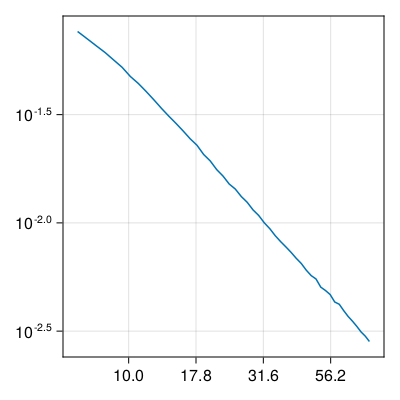

CairoMakie.Screen{IMAGE}


In [188]:
bins_midpoints = 0.5*(bins[1:end-1] + bins[2:end])
hstr = string(@sprintf("%02d", corona.height))
istr = string(@sprintf("%02d", corona.spectral_index))
filename = "$(modelname)$(modelid)_h$(hstr)_idx$(istr)"
savename = "io/corona/bosonstar/$(filename).txt"
figname = "plots/profiles/$(filename).png"

savedata = true
plotfig = true
if savedata
    open(savename, "w") do io
        writedlm(io, [bins_midpoints I])
    end
end

if plotfig
    fig = Figure(resolution=(400,400))
    ax = Axis(fig[1,1])
    lines!(ax, bins_midpoints, 𝓝)
    ax.xscale = log10
    ax.yscale = log10
    # xlims!(1.0,200)
    # ylims!(1e-6, 1e0)
    ax.xtickformat = "{:.1f}"
    display(fig)
    CairoMakie.save(figname, fig)
end

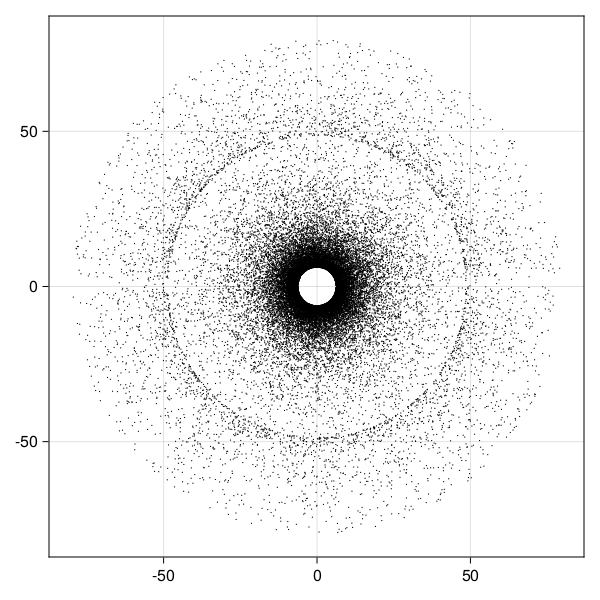

In [133]:
fig = Figure(resolution=(600,600))
ax = Axis(fig[1,1])

rr = output_data[2,at_source]
phi = output_data[4,at_source]

x = rr.*cos.(phi)
y = rr.*sin.(phi)

scatter!(ax, x, y, markersize=1.8, color=:black)
fig

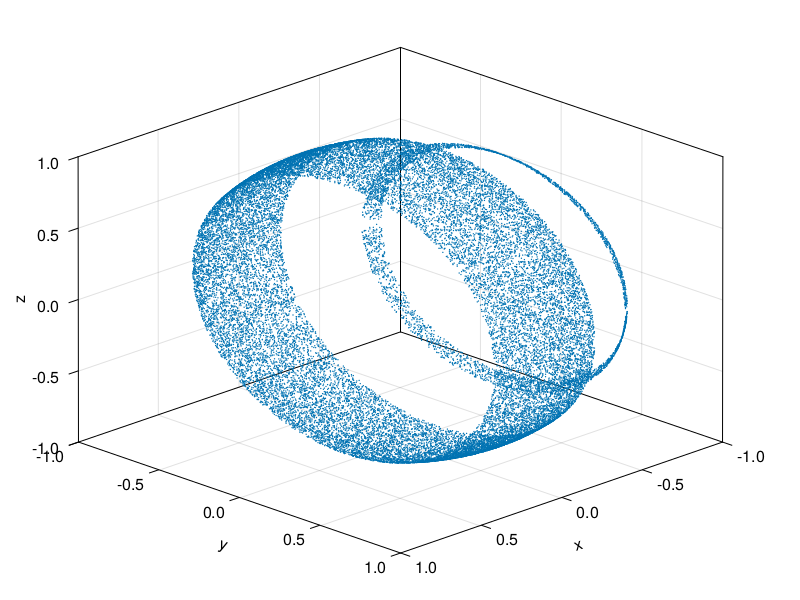

In [164]:
CairoMakie.activate!()

g = metric(initial_data[1:4,1],spacetime)

kr = initial_data[2+4,:]
kθ = initial_data[3+4,:]
kφ = initial_data[4+4,:]

filter = true
if filter
    kr = initial_data[2+4,at_source]
    kθ = initial_data[3+4,at_source]
    kφ = initial_data[4+4,at_source]
end

∂r = [0.0, 1.0, 0.0, 0.0]
∂θ = [0.0, 0.0, 1.0, 0.0]
∂φ = [0.0, 0.0, 0.0, 1.0]

nr = sqrt(Skylight.norm_squared(∂r, g))
nθ = sqrt(Skylight.norm_squared(∂θ, g))
nφ = sqrt(Skylight.norm_squared(∂φ, g))

fig = Figure()
ax = Axis3(fig[1, 1], azimuth = 45*(π/180), elevation = 20*(π/180))
scatter!(ax, kr.*nr, kθ.*nθ, kφ.*nφ, markersize=2.0)
xlims!(ax, -1.0, 1.0)
ylims!(ax, -1.0, 1.0)
zlims!(ax, -1.0, 1.0)
fig

In [151]:
fig

Boson star

In [16]:
bins_midpoints, I = calculate_profile("SBS", 3; height=10.0, npp=100000, nbins=50, save=false, plot=false)

┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=9.910216244343122, and step error estimate = 1.5360429966108562. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=0.0002454114550215026, and step error estimate = 0.6084503173683884. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:606
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=10.05182792768031, and step error estimate = 0.6084532627403549. Aborting. There is either an error in your model specification o

Equations integration stats:
Wall clock time: 3.212896786 seconds
Memory allocated: 11.938 GiB


MethodError: MethodError: no method matching iterate(::Nothing)

Closest candidates are:
  iterate(!Matched::Union{LinRange, StepRangeLen})
   @ Base range.jl:880
  iterate(!Matched::Union{LinRange, StepRangeLen}, !Matched::Integer)
   @ Base range.jl:880
  iterate(!Matched::T) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}}
   @ Base dict.jl:698
  ...


In [2]:
bins_midpoints

UndefVarError: UndefVarError: `bins_midpoints` not defined

In [54]:
modelname = "SBS"
modelid = 3
filenames = get_filenames(modelname)
obs_configurations = load_configurations_from_hdf5("io/$(filenames[modelid,1]).h5")
spacetime = obs_configurations.spacetime
disk = obs_configurations.radiative_model

AccretionDiskWithTabulatedTemperature{ProgradeRotation, DataInterpolations.LinearInterpolation{Vector{Float64}, Vector{Float64}, true, Float64}}
  inner_radius: Float64 6.8
  outer_radius: Float64 79.8
  rotation_sense: ProgradeRotation ProgradeRotation()
  filename: String "tables/TempSBS3.dat"
  temperature_interpolator: DataInterpolations.LinearInterpolation{Vector{Float64}, Vector{Float64}, true, Float64}


In [55]:
corona = LamppostCorona(height=10.0, theta_offset=1e-5, spectral_index = 2.0)
configurations = VacuumETOConfigurations(spacetime=spacetime,
                                   radiative_model = corona,
                                   number_of_points=1,
                                   number_of_packets_per_point = 1000000, 
                                   max_radius = 110.0,
                                   unit_mass_in_solar_masses=1.0)
initial_data = initialize(configurations)
cbp = callback_parameters(spacetime, disk, configurations)
cb = callback(spacetime, disk)
sim = integrate(initial_data, configurations, cb, cbp; method=VCABM(), reltol=1e-5, abstol=1e-5)
output_data = sim.output_data
at_source = map(position -> is_final_position_at_source(position, spacetime, disk) && position[3] ≈ π/2, eachcol(output_data))
radii = output_data[2,at_source]
q = energies_quotients(output_data[:,at_source], spacetime, disk)


┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=11.655789947348337, and step error estimate = NaN. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=10.088137245352467, and step error estimate = 0.5021457442187571. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=10.064451019093227, and step error estimate = 1.0. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <=

┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=9.609250279991029, and step error estimate = 0.7167758429740481. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=10.275362243687974, and step error estimate = 1.0. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=15.638101333111393, and step error estimate = 0.693164659774325. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.32830643653

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:606


┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=0.00010065208608239738, and step error estimate = 0.4014328363271302. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599


┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=9.881214878679348, and step error estimate = 1.873788705100247. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599


┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=9.87770387193464, and step error estimate = 0.49353398443020063. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599


┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=9.881652419276852, and step error estimate = 0.808563509869766. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:580


Equations integration stats:
Wall clock time: 61.254878593 seconds
Memory allocated: 120.189 GiB


416937-element Vector{Float64}:
 1.05436734504865
 1.135308435058533
 0.9909870667851592
 1.1079969662727773
 0.9672146417215111
 1.0181476633003894
 1.0766560003830834
 0.9705437789273695
 0.9755575989217505
 1.0303556118399886
 ⋮
 1.0910411431485156
 0.9990000570689627
 1.041097112466554
 1.0251838174797883
 1.1776196935878314
 0.9256839752662731
 0.9385066611089892
 0.9906799279650826
 0.9466733053501576

In [7]:
# bins = radial_bins(disk, nbins=100)
bins = range(cbrt(disk.inner_radius), stop=cbrt(disk.outer_radius), length=50).^3
A = ring_areas(bins, spacetime)
γ = lorentz_factors(bins, spacetime, disk)
h = fit(Histogram, radii, bins)
h = normalize(h, mode=:probability)
𝓝 = h.weights

qavg = average_inside_radial_bins(q, radii, bins)

Γ = corona.spectral_index
n = 𝓝./(A.*γ)
I = qavg.^Γ.*n

bins_midpoints = 0.5*(bins[1:end-1] + bins[2:end])
nothing

In [8]:
hstr = string(@sprintf("%02d", corona.height))
istr = string(@sprintf("%02d", corona.spectral_index))
filename = "io/corona/bosonstar/$(modelname)$(modelid)_h$(hstr)_idx$(istr).txt"
open(filename, "w") do io
    writedlm(io, [bins_midpoints I])
end


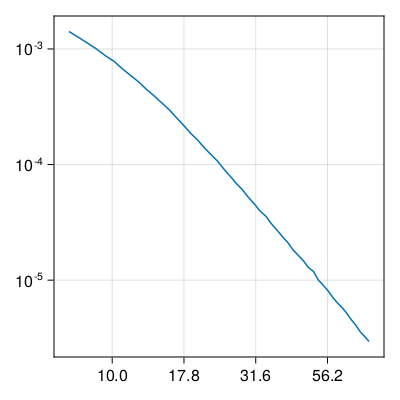

In [9]:

fig = Figure(resolution=(400,400))
ax = Axis(fig[1,1])
lines!(ax, bins_midpoints, I)
ax.xscale = log10
ax.yscale = log10
# xlims!(1.0,200)
# ylims!(1e-6, 1e0)
ax.xtickformat = "{:.1f}"
fig

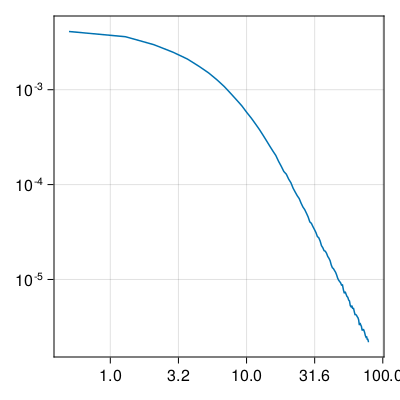

In [ ]:
hstr = string(@sprintf("%02d", corona.height))
istr = string(@sprintf("%02d", corona.spectral_index))
filename = "io/corona/bosonstar/$(modelname)$(modelid)_h$(hstr)_idx$(istr).txt"
open(filename, "w") do io
    writedlm(io, [bins_midpoints I])
end

fig = Figure(resolution=(400,400))
ax = Axis(fig[1,1])
lines!(ax, bins_midpoints, I)
ax.xscale = log10
ax.yscale = log10
# xlims!(1.0,200)
# ylims!(1e-6, 1e0)
ax.xtickformat = "{:.1f}"
fig

In [43]:
bins_midpoints[40]

31.5025

In [62]:
imin = 25
df = DataFrame(logr = log10.(bins_midpoints[imin:end]), logI = log10.(I[imin:end]))
ols = lm(@formula(logI ~ logr), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

logI ~ 1 + logr

Coefficients:
───────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error        t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)   0.155585   0.0211157     7.37    <1e-06   0.111903   0.199266
logr         -3.00162    0.0124221  -241.64    <1e-39  -3.02732   -2.97592
───────────────────────────────────────────────────────────────────────────

Kerr black hole

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:606
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=3.588009004707537e-5, and step error estimate = 1.5336528319228255. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/jpelle/.julia/packages/SciMLBase/qp2gL/src/integrator_interface.jl:599
┌ Warning: dt(2.3283064365386963e-10) <= dtmin(2.3283064365386963e-10) at t=20.727226852539957, and step error estimate = 2.232577940388

Equations integration stats:
Wall clock time: 38.707425401 seconds
Memory allocated: 128.829 GiB


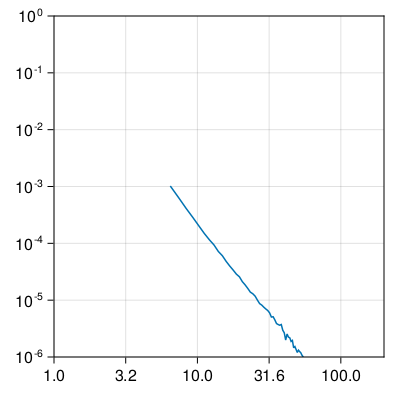

In [8]:
spacetime = KerrSpacetimeBoyerLindquistCoordinates(M=1.0,a=0.0)
corona = LamppostCorona(height=2.5, theta_offset=1e-5, spectral_index = 2.0)
configurations = VacuumETOConfigurations(spacetime=spacetime,
                                   radiative_model = corona,
                                   number_of_points=1,
                                   number_of_packets_per_point = 1000000, 
                                   max_radius = 110.0,
                                   unit_mass_in_solar_masses=1.0)
initial_data = initialize(configurations)
disk = NovikovThorneDisk(inner_radius = isco_radius(spacetime, ProgradeRotation()), outer_radius = 100.0)
cbp = callback_parameters(spacetime, disk, configurations; rhorizon_bound=2e-3)
cb = callback(spacetime, disk)
sim = integrate(initial_data, configurations, cb, cbp; method=VCABM(), reltol=1e-5, abstol=1e-5)
output_data = sim.output_data
at_source = map(ray -> is_final_position_at_source(ray[1:4], spacetime, disk) && ray[3] ≈ π/2 && abs(Skylight.norm_squared(ray[5:8], metric(ray[1:4], spacetime))) < 1e-2, eachcol(output_data))
radii = output_data[2,at_source]
q = energies_quotients(output_data[:,at_source], spacetime, disk)
bins = radial_bins(disk, nbins=100)
# bins = r_in*exp10.(range(0.0, stop=log10(r_out/r_in), length=100))
A = ring_areas(bins, spacetime)
γ = lorentz_factors(bins, spacetime, disk)
h = fit(Histogram, radii, bins)
h = normalize(h, mode=:probability)
𝓝 = h.weights

qavg = average_inside_radial_bins(q, radii, bins)

Γ = corona.spectral_index
n = 𝓝./(A.*γ)
I = qavg.^Γ.*n

bins_midpoints = 0.5*(bins[1:end-1] + bins[2:end])

astr = string(@sprintf("%02d", spacetime.a))
hstr = string(@sprintf("%02d", corona.height))
istr = string(@sprintf("%02d", corona.spectral_index))
filename = "io/corona/kerr/a$(astr)_h$(hstr)_idx$(istr).txt"
open(filename, "w") do io
    writedlm(io, [bins_midpoints I])
end

fig = Figure(resolution=(400,400))
ax = Axis(fig[1,1])
lines!(ax, bins_midpoints, I)
ax.xscale = log10
ax.yscale = log10
xlims!(1.0,200)
ylims!(1e-6, 1e0)
ax.xtickformat = "{:.1f}"
fig

In [18]:
hstr = string(@sprintf("%.1f", 10))

"10.0"

In [15]:
df = DataFrame(logr = log10.(bins_midpoints[16:end]), logI = log10.(I[16:end]))
ols = lm(@formula(logI ~ logr), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

logI ~ 1 + logr

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error        t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)   0.020696  0.0154046      1.34    0.1883  -0.0106449   0.0520368
logr         -2.99434   0.00856143  -349.75    <1e-59  -3.01175    -2.97692
─────────────────────────────────────────────────────────────────────────────